## Abusive Email Classifer

#### Business Objective:
* Inappropriate emails would demotivates and spoil the positive environment that would lead to more attrition rate and low productivity and Inappropriate emails could be on form of bullying, racism, sexual favoritism and hate in the gender or culture, in today's world so dominated by email no organization is immune to these hate emails.
* The goal of the project is to identify such emails on the given day based on the above inappropriate content.

### Data Set Details:
* The dataset contains more than 2 lakh emails generated by employees of an organization.
* Data set details sent in csv file.

### 1. Introduction
The project basically classifies text input based on context as abusive or non abusive. Email Classification includes a lot of preprocessing mostly and the modelling and training part in this problem is relatively simple. Our primary goal is to make a more generalised text classifier that is trained on an email dataset which is hand-labelled as abusive/non-abusive. However, while going through the EDA, we realise the significant flaws within this dataset. But we have used advanced feature extraction techniques to squeeze the maximum out our dataset. Our deep learning model; however merges two dataset and balances them which puts it at a huge advantage compared to our baseline machine learning models. Finally we will discuss on our deployment of the project.

### 1.1 What we understood:
1. After a thorough research and comparing various research papers and works, we arrived at the following conclusions:
    * No model can ever be at par with human intelligence for abusive/profanity classification.
    * The word combinations in the language is simply infinite and people can get creative:
        * Eg1: “f4ck you” or “you b1tch”
        * Eg2: Are you willing to say that any sentence containing the word “suck” is abusive?
        * Eg3: “I want to stick my long-necked Giraffe up your fluffy white bunny.”
    * To train a model of this complexety, advanced deep learning technologies must be employed to work effectively against these contexts.

### 2. Libraries

In [1]:
#Basic Libraries

import pandas as pd 
import numpy as np
import re
import numpy
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For NLP & Preprocessing

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from wordcloud import WordCloud,STOPWORDS #Better stopwords here
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
#Visualizations

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

#Setting Dark Theme
sns.set(rc={'figure.figsize':(10,6.18)})
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [4]:
#Machine Learning Libraries

#For Linear SVC
from sklearn.svm import LinearSVC
#For Naive Bayes
from sklearn.naive_bayes import MultinomialNB
#For logistic Regression
from sklearn.linear_model import LogisticRegression
#For XGBoost Classifier
from xgboost import XGBClassifier
#For Perceptron
from sklearn.linear_model import Perceptron
#For Support Vector Machine
from sklearn.svm import SVC
#For ensemble Models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

#For model validation
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

#To generate model report
from sklearn.metrics import plot_confusion_matrix,classification_report

#To save the mo
import joblib

In [5]:
#Deep Learning Libraries - Bidirectional LSTM

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

### Exploratory Data Analysis

#### 3.1 Data Exploration

In [6]:
dataset = pd.read_csv("raw_data.csv")
dataset.drop('Unnamed: 0',axis=1,inplace=True)
dataset.head()

,filename,Message-ID,content,Class
0,arnold-j/_sent_mail/34.,<15267340.1075857594923.JavaMail.evans@thyme>,eat shit\n\n\n\n\nJohn J Lavorato@excelr\n11/1...,Abusive
1,arnold-j/_sent_mail/517.,<15539583.1075857652152.JavaMail.evans@thyme>,fuck you,Abusive
2,arnold-j/_sent_mail/743.,<4339799.1075857657711.JavaMail.evans@thyme>,Gentlemen:\nThe following champagne is availab...,Abusive
3,arnold-j/_sent_mail/766.,<25574783.1075857658215.JavaMail.evans@thyme>,sorry i've taken so long...just been trying to...,Abusive
4,arnold-j/_sent_mail/797.,<19506151.1075857658895.JavaMail.evans@thyme>,asshole\n\n\n\n\nJohn J Lavorato@excelr\n12/23...,Abusive


In [7]:
dataset.info() #No null values are visible

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48076 entries, 0 to 48075
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    48076 non-null  object
 1   Message-ID  48076 non-null  object
 2   content     48076 non-null  object
 3   Class       48076 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB


In [8]:
dataset.describe()
#notice that there are atually 24k values only for content whereas the rest are duplicated

,filename,Message-ID,content,Class
count,48076,48076,48076,48076
unique,48076,48076,24656,2
top,arnold-j/_sent_mail/34.,<15267340.1075857594923.JavaMail.evans@thyme>,Ken Lay and Jeff Skilling were interviewed on ...,Non Abusive
freq,1,1,19,44666


In [9]:
dataset.shape #There 48k records and 4 columns

(48076, 4)

In [10]:

dataset.columns

Index(['filename', 'Message-ID', 'content', 'Class'], dtype='object')

#### 3.1.1 Removing Unwanted features
After examining filename and Message-ID, we came to the conclusion that these two columns are not useful in our Modelling. We will drop those columsn

In [11]:
dataset.drop(['filename', 'Message-ID'],axis=1,inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48076 entries, 0 to 48075
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  48076 non-null  object
 1   Class    48076 non-null  object
dtypes: object(2)
memory usage: 751.3+ KB


#### 3.1.2 Duplicate value check
There are duplicate values in Content which is fundamental to our project. We will remove those duplicate values.

In [12]:
# No of unique values under every column
dataset.nunique() 
#There are clear number of duplicates in content which is fundamental in our project. We will remove it during preprocessing

content    24656
Class          2
dtype: int64

In [13]:
dataset.drop_duplicates(inplace=True)

In [14]:
dataset.reset_index()
dataset.head()

,content,Class
0,eat shit\n\n\n\n\nJohn J Lavorato@excelr\n11/1...,Abusive
1,fuck you,Abusive
2,Gentlemen:\nThe following champagne is availab...,Abusive
3,sorry i've taken so long...just been trying to...,Abusive
4,asshole\n\n\n\n\nJohn J Lavorato@excelr\n12/23...,Abusive


In [15]:
dataset.tail()

,content,Class
47974,Do you need new leads for your business ?\n D...,Non Abusive
47975,"[IMAGE]\n [IMAGE] [IMAGE] GARTH BROOKS ""...",Non Abusive
47977,\n[IMAGE][IMAGE][IMAGE] \nDear SmartReminders ...,Non Abusive
47980,\n[IMAGE]\n [IMAGE] [IMAGE] [IMAGE] KID ...,Non Abusive
47981,\nYou received this e-mail because you registe...,Non Abusive


#### 3.1.3 Null value check

In [16]:
#checking for Null Values
dataset.isna().sum()

content    0
Class      0
dtype: int64

In [17]:
dataset.dropna(inplace=True) #To remove the webscrapped from original csv file

In [18]:
#EDA Dataset
dataset.head()

,content,Class
0,eat shit\n\n\n\n\nJohn J Lavorato@excelr\n11/1...,Abusive
1,fuck you,Abusive
2,Gentlemen:\nThe following champagne is availab...,Abusive
3,sorry i've taken so long...just been trying to...,Abusive
4,asshole\n\n\n\n\nJohn J Lavorato@excelr\n12/23...,Abusive


In [19]:
#EDA Dataset Shape
dataset.shape

(24656, 2)

#### 3.2 Feature Analysis

In [20]:
dataset.rename({'content':'text','Class':'target'},axis=1,inplace=True) #Renaming for easier use
dataset.head()

,text,target
0,eat shit\n\n\n\n\nJohn J Lavorato@excelr\n11/1...,Abusive
1,fuck you,Abusive
2,Gentlemen:\nThe following champagne is availab...,Abusive
3,sorry i've taken so long...just been trying to...,Abusive
4,asshole\n\n\n\n\nJohn J Lavorato@excelr\n12/23...,Abusive


#### 3.2.1 Target

In [21]:
#The column Class is our target. We wil check for its value counts
dataset.target.value_counts() 
#There is a critical bias within the dataset. We could try balancing after vectorization but it is not advised

Non Abusive    23014
Abusive         1642
Name: target, dtype: int64

In [22]:
#Percentage counts
dataset.target.value_counts(normalize=True)

Non Abusive    0.933404
Abusive        0.066596
Name: target, dtype: float64

<AxesSubplot:xlabel='target', ylabel='count'>

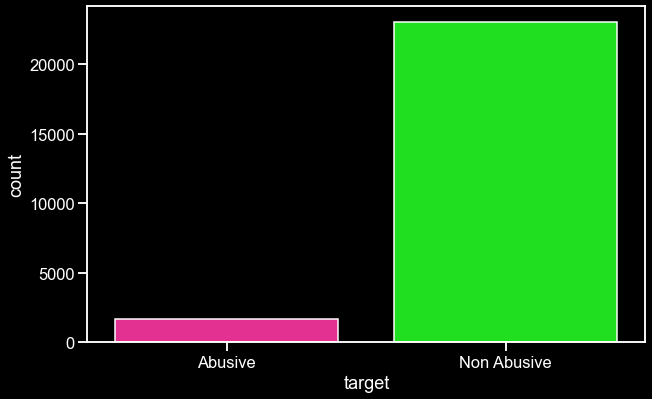

In [23]:
sns.countplot(dataset.target, palette=["deeppink","lime"])
#Biased Distribution of Target

### Managing the Imbalance:
* After we vectorize the text, we could resample the numerical values to balance the dataset. This would work well with any regression problems! However, it will not work well with NLP problems as in our case. There are numerous possibilities in language and randomly generating values for our problem will not help in anyway. It will just create a poor model with no balance between precision and recall
* We had experimented with a number of resampling techniques like SMOTE Tomek, Stratify Split, RandomUnderSampler which proved to futile during Modelling as we obtained very poor values.
* However, we will include them to prove our point.
* For our deep learning approach, we tried out a different approach which will be discussed later on. The deep learning model is practically very applicable to real world scenarios.

#### 3.2.2 Text

In [24]:
text_len=[len(x) for x in dataset.text]

In [25]:
outlier = [y for y in text_len if y > 1000]
len(outlier)

10023

In [26]:
dataset.length = dataset.text.apply(lambda x : len(x))

<AxesSubplot:xlabel='text', ylabel='Count'>

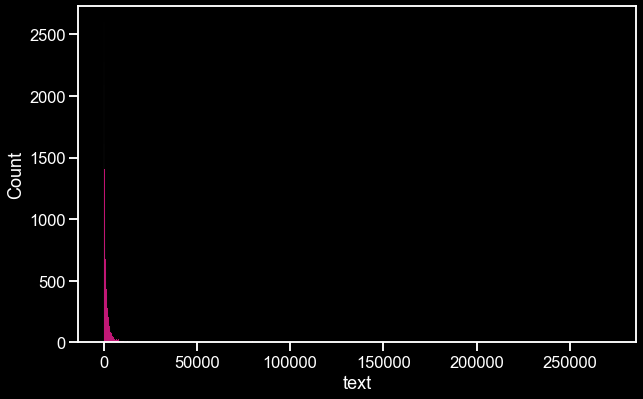

In [27]:
sns.histplot(dataset.length, color='deeppink')

There are huge outliers which we need to remove. We will remove the outliers after preprocessing

### 4. Preprocessing
##### 4.1 Cleaning data
* There are a number of special characters and other values that needs to be removed. We will define a clean text function to remove it.
* This function will convert all text to lower case
* We will add email headers ("from","to","subject","cc") to a custom stopword list and remove it.

##### 4.2 Freq. of Words, Custom Stop Word Removal & Word Cloud
* Freq. distribution of words will be viewed and certain useless words will be added to custom stop word list.
* Word cloud before and after custom stopword removal will be viewed

##### 4.3 Chat words abbrevation replacements
* Short forms like IDK, WTF, ILU etc will be replaced with their abbrevations.

##### 4.4 Removing records that exceed word limit
* If number of words exceed a certain characters, we will remove it.

##### 4.5 Lemmatization

In [28]:
# Make a different Dataset
df = dataset.copy()
df.head()

,text,target
0,eat shit\n\n\n\n\nJohn J Lavorato@excelr\n11/1...,Abusive
1,fuck you,Abusive
2,Gentlemen:\nThe following champagne is availab...,Abusive
3,sorry i've taken so long...just been trying to...,Abusive
4,asshole\n\n\n\n\nJohn J Lavorato@excelr\n12/23...,Abusive


#### 4.1 Cleaning data

In [29]:
#Before cleaning
df.text.head()

0    eat shit\n\n\n\n\nJohn J Lavorato@excelr\n11/1...
1                                             fuck you
2    Gentlemen:\nThe following champagne is availab...
3    sorry i've taken so long...just been trying to...
4    asshole\n\n\n\n\nJohn J Lavorato@excelr\n12/23...
Name: text, dtype: object

In [30]:
# Clean The Data using RegEx
#result = re.sub(pattern, replacement, string, count=0, flags=0)

def cleantext(text):
    text = re.sub(r"\n", " ", text) #remove next "\n"
    text = re.sub(r"[\d-]", "", text) #remove all digits 
    text = re.sub(r'[^A-Za-z0-9]+', " ", text) #remove all special charcters
    text = text.lower()
    return text

#Apply to our dataset
df.text = df.text.apply(cleantext)
df.text.head()

0    eat shit john j lavorato excelr pm to john arn...
1                                             fuck you
2    gentlemen the following champagne is available...
3    sorry i ve taken so long just been trying to f...
4    asshole john j lavorato excelr am to john arno...
Name: text, dtype: object

#### 4.2 Freq. of Words, Custom Stop Word Removal & Word Cloud

In [31]:
#making a corpus of the dataset
review_str = ' '.join(df.text.tolist())

In [32]:
text = review_str
words = text.split()
fdsit1 = FreqDist(words)
print(fdsit1)
print(fdsit1.most_common(100))

#Words which are not in inbuilt stopwords are noted

<FreqDist with 108184 samples and 6333551 outcomes>
[('the', 230269), ('to', 170656), ('and', 111670), ('a', 103209), ('of', 91991), ('in', 72369), ('for', 66037), ('you', 64086), ('com', 63660), ('excelr', 63544), ('i', 56901), ('on', 52955), ('is', 52504), ('s', 48628), ('that', 44556), ('this', 42561), ('ect', 40014), ('from', 37682), ('be', 37124), ('with', 34705), ('will', 33845), ('td', 33107), ('at', 32503), ('we', 32498), ('have', 31411), ('it', 29349), ('are', 29148), ('http', 28947), ('your', 27508), ('as', 27094), ('font', 27039), ('or', 26525), ('by', 23643), ('if', 23138), ('not', 22117), ('hou', 20044), ('subject', 18520), ('am', 17701), ('pm', 17424), ('please', 17034), ('www', 16095), ('all', 16003), ('d', 15761), ('t', 15712), ('email', 15212), ('an', 14936), ('he', 14898), ('was', 14743), ('can', 14508), ('has', 13973), ('our', 13664), ('b', 13555), ('me', 13511), ('would', 12835), ('any', 12818), ('message', 12792), ('but', 12769), ('image', 12535), ('time', 12507), 

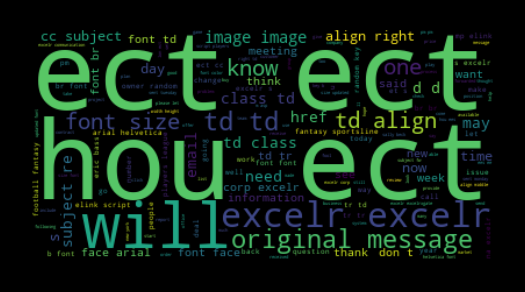

In [33]:
#Creating a WordCloud1
#font_path = '..\\miscellaneous\\Metropolis-Black'
wordcloud_ip = WordCloud(
                      background_color="black", max_words=500,
               stopwords=STOPWORDS, max_font_size=200,
               random_state=42).generate(review_str)
figure(figsize=(2,3), dpi=300)
plt.imshow(wordcloud_ip,interpolation="bilinear")
plt.axis("off")
plt.show()

#Words which have no emotional meaning are noted and added to our custom stopword list

In [34]:
# Custom Stop Words list
# We made a custom stopwords set specific to our current dataset
with open("custom_stopwords.txt","r") as stop:
  custom_stop = set(stop.read().split("\n"))

In [35]:
# We can create a new stopwords list by mergeing WordCLoud's STOPWORDS and our custom_stop
custom_stop = custom_stop.union(STOPWORDS)
len(custom_stop)

751

In [36]:
df.text = df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in custom_stop]))
df.text

0        eat shit lavorato bets minn buff phil indi cin...
1                                                     fuck
2        gentlemen champagne approximate retail interes...
3        long fend chicks life sooooo hard monkey brian...
4        asshole lavorato gambling problem bills denver...
                               ...                        
47974    leads increased internet exposure thousands jo...
47975    garth brooks wrapped win tickets trip garth br...
47977    dear smartreminders member franchoice oneonone...
47980    kid rock forever official kid rock kidrock coc...
47981    registered trade web partners sites partner of...
Name: text, Length: 24656, dtype: object

In [37]:
#making a corpus of the dataset after custom stop word removal
review_str_2 = ' '.join(df.text.tolist())

In [38]:
#Checking Freq Distribution for new corpus
text = review_str_2
words = text.split()
fdsit2 = FreqDist(words)
print(fdsit2)
print(fdsit2.most_common(100))

<FreqDist with 107502 samples and 2599162 outcomes>
[('class', 7963), ('fantasy', 6138), ('click', 5318), ('today', 4907), ('report', 4846), ('buy', 4798), ('arial', 4708), ('random', 4594), ('width', 4537), ('good', 4383), ('league', 4337), ('owner', 3981), ('home', 3905), ('gif', 3818), ('script', 3805), ('news', 3757), ('images', 3667), ('rick', 3618), ('helvetica', 3582), ('deal', 3511), ('elink', 3416), ('people', 3395), ('center', 3375), ('color', 3301), ('mark', 3224), ('number', 3155), ('start', 3141), ('left', 3121), ('great', 3106), ('order', 3012), ('change', 3008), ('offer', 2986), ('border', 2909), ('final', 2880), ('find', 2860), ('forward', 2781), ('give', 2764), ('bgcolor', 2752), ('fool', 2702), ('online', 2684), ('end', 2648), ('phtml', 2602), ('issues', 2600), ('html', 2590), ('working', 2587), ('description', 2586), ('stock', 2547), ('height', 2537), ('request', 2525), ('support', 2516), ('nyiso', 2515), ('made', 2503), ('play', 2456), ('plan', 2437), ('phone', 2427

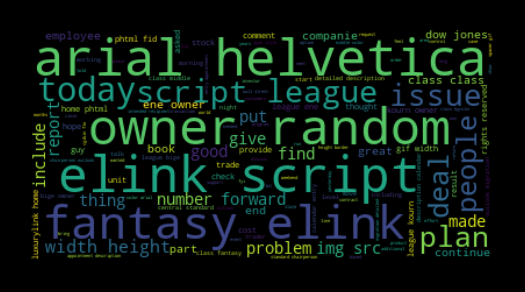

In [39]:
#Creating a WordCloud2
#font_path = '..\\miscellaneous\\Metropolis-Black'
wordcloud_ip = WordCloud(
                      background_color="black", max_words=500,
               stopwords=STOPWORDS, max_font_size=200,
               random_state=42).generate(review_str_2)
figure(figsize=(2,3), dpi=300)
plt.imshow(wordcloud_ip,interpolation="bilinear")
plt.axis("off")
plt.show()
#We have removed high frequency useless words from the dataset
#The words below are low frequency words

#### 4.3 Chat words abbrevation replacements
Short form words will be removed from our dataset

In [40]:
# Custom Stop Words list
# We made a custom stopwords set specific to our current dataset
with open("chat_abbr.txt","r") as stop:
  chat_words = list(stop.read().split("\n"))

In [41]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words:
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

df.text = df.text.apply(lambda text: chat_words_conversion(text))

#### 4.4 Removing records that exceed word limit¶
We have a large frequency of texts between 0 to 500 range. Rest of the texts are just outliers and do not add any value to our overall modelling. Email Texts with excessive words make it difficult due to large number of features.

In [42]:
df["length"] = df.text.apply(lambda x : len(x))

<AxesSubplot:xlabel='length', ylabel='Count'>

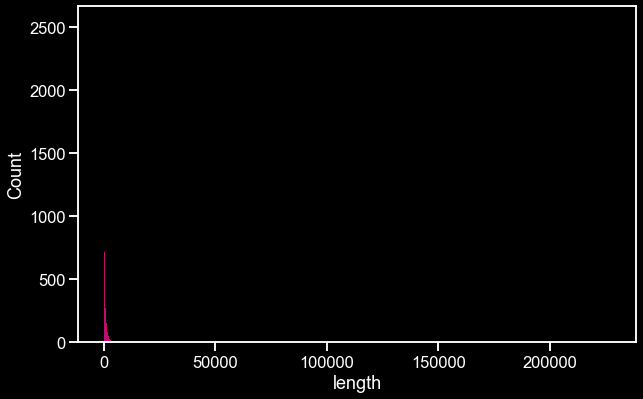

In [43]:
sns.histplot(df.length, color='deeppink') #huge outliers must be removed

In [44]:
df.target.loc[df.length>1500].value_counts() 
#We could remove these to ease the modelling process.
#There is dataleak here since we are loosing some of the data but we are gaining an advantage in modelling.
# We will drop these outliers

Non Abusive    2581
Abusive         234
Name: target, dtype: int64

In [45]:
df1 = df.loc[df.length<1500].copy() #Make a dataset copy
df1.head()

,text,target,length
0,eat shit lavorato bets minn buff phil indi cin...,Abusive,72
1,fuck,Abusive,4
2,gentlemen champagne approximate retail interes...,Abusive,369
3,long fend chicks life sooooo hard monkey brian...,Abusive,140
4,asshole lavorato gambling problem bills denver...,Abusive,51


<AxesSubplot:xlabel='length', ylabel='Count'>

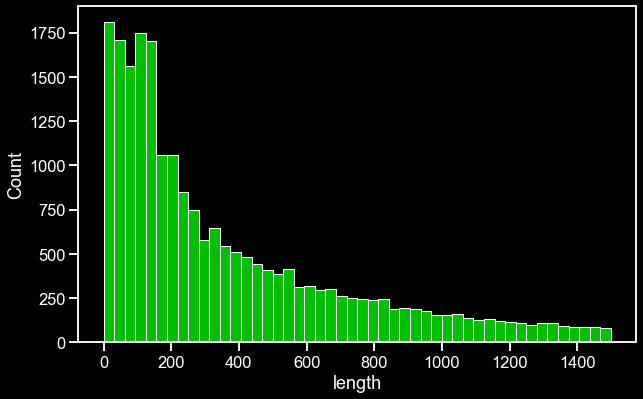

In [46]:
sns.histplot(df1.length, color='lime') #Outliers have been removed

In [47]:

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21839 entries, 0 to 47980
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21839 non-null  object
 1   target  21839 non-null  object
 2   length  21839 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 682.5+ KB


#### 4.5 Lemmatization

In [48]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df1.text = df1.text.apply(lambda text: lemmatize_words(text))
df1.head()

,text,target,length
0,eat shit lavorato bet minn buff phil indi cinn...,Abusive,72
1,fuck,Abusive,4
2,gentleman champagne approximate retail interes...,Abusive,369
3,long fend chick life sooooo hard monkey brian ...,Abusive,140
4,asshole lavorato gambling problem bill denver ...,Abusive,51


### 5. Advanced Feature Analysis
#### 5.1 Adding Sentiment Polarity & WordCount

In [49]:
sent_analyzer = SentimentIntensityAnalyzer()
#Function to retrieve sentiment polarity
def get_senti_class(review): 
    analysis = sent_analyzer.polarity_scores(review)
    return analysis["compound"]

In [50]:
df1['polarity'] = df1['text'].apply(lambda text: get_senti_class(text))

In [51]:
df1['target']=np.where(df1['target']=='Abusive',1,0)

In [52]:
df1['word_count'] = df1['text'].apply(lambda text: len(text.split()))
df1.head()

,text,target,length,polarity,word_count
0,eat shit lavorato bet minn buff phil indi cinn...,1,72,-0.5574,14
1,fuck,1,4,-0.5423,1
2,gentleman champagne approximate retail interes...,1,369,0.8555,49
3,long fend chick life sooooo hard monkey brian ...,1,140,-0.6124,22
4,asshole lavorato gambling problem bill denver ...,1,51,-0.4019,7


#### 5.2 Length, Polarity & WordCount Distributions

<AxesSubplot:xlabel='length', ylabel='Density'>

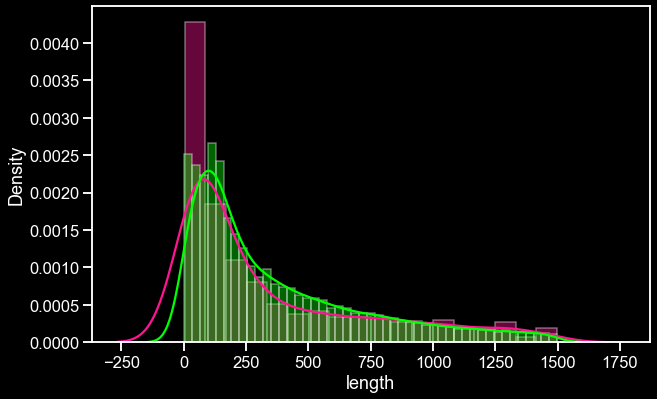

In [53]:
#Length Distribution Plot
sns.distplot(df1["length"].loc[df1.target==1], hist=True,color='deeppink')#Abusive
sns.distplot(df1["length"].loc[df1.target==0], hist=True,color='lime') #Non Abusive

<AxesSubplot:xlabel='polarity', ylabel='Density'>

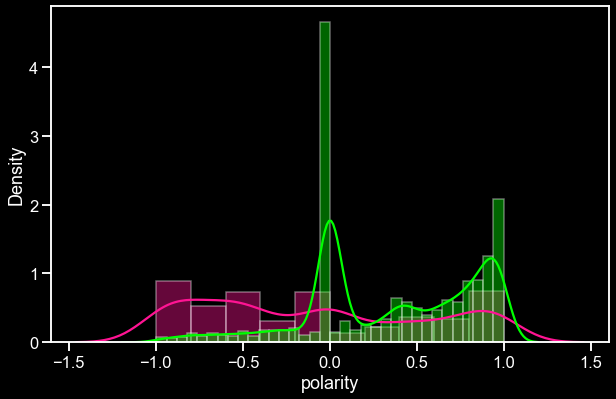

In [54]:
#Polarity Distribution Plot
sns.distplot(df1["polarity"].loc[df1.target==1], hist=True,color='deeppink')#Abusive
sns.distplot(df1["polarity"].loc[df1.target==0], hist=True,color='lime') #Non Abusive
#There are a large number of neutral statements
#It can be observed that the mean polarity of non_abusive emails is almost similar to the mean polarity of abusive emails. 
#Hence both the mean of absive and non_abusive emails shows 'neutral' polarity

<AxesSubplot:xlabel='word_count', ylabel='Density'>

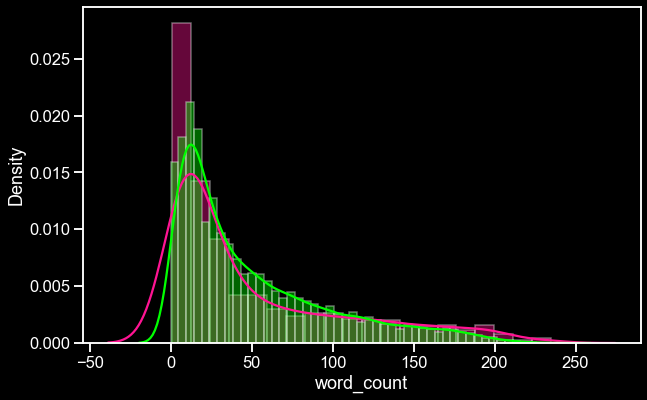

In [55]:
#WordCount Distribution Plot
sns.distplot(df1["word_count"].loc[df1.target==1], hist=True,color='deeppink')#Abusive
sns.distplot(df1["word_count"].loc[df1.target==0], hist=True,color='lime') #Non Abusive

### 6. Vectorization
#### 6.1 CountVectorizer

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=10000)

X_count = cv.fit_transform(df1["text"])

In [57]:
X_count.shape

(21839, 10000)

In [58]:
X_count

<21839x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 708882 stored elements in Compressed Sparse Row format>

In [59]:
y = df1.target

#### 6.2 Stratified Train Test Split - Balancing the Data
* The stratified sampling is designed to equally distribute some features in the next train and test sets.

In [60]:
# split into train test sets
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.30, random_state=1, stratify=y)
#We will vectorize train and test seperately to avoid mixing

### 6.3 TFIDF Transformer

In [61]:
#Transform To TFIDF Vector
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train_count)
X_test = tfidf_transformer.fit_transform(X_test_count)
print(X_train.shape)
print(X_test.shape)

(15287, 10000)
(6552, 10000)


### 7. Machine Learning Modelling
* We will try out different baseline machine Modelling approach and generate the classfication report for each of them.
* We will analyze and understand why such baseline models fail in the case of real world dataset.

#### 7.1 Model Validation - Stratified K-Fold

In [62]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

In [63]:
def report(model):
    preds = model.predict(X_test)
    print(classification_report(y_test,preds))
    plot_confusion_matrix(model,X_test,y_test)

#### 7.2 Baseline Models
##### 7.2.1 Logistic Regression

In [64]:
### Logisitic Regression

LR = LogisticRegression()

#Parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [300, 200, 100, 10]

#ParametersGrid
lr_param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

#GridSearchCV
gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsLR.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [300, 200, 100, 10], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy', verbose=1)

Best : 0.9767776750140612, using {'C': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6130
           1       0.92      0.76      0.83       422

    accuracy                           0.98      6552
   macro avg       0.95      0.88      0.91      6552
weighted avg       0.98      0.98      0.98      6552



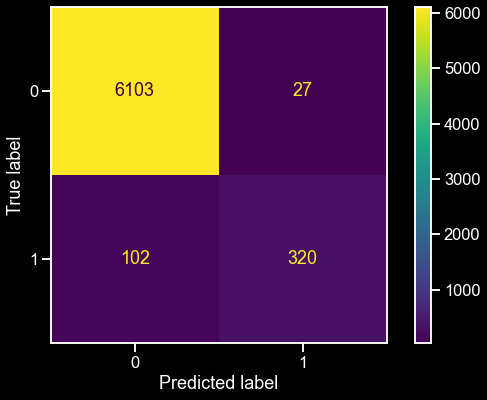

In [65]:
# Summarize the results
LR_best = gsLR.best_estimator_
print('Best : {}, using {}'.format(gsLR.best_score_,gsLR.best_params_))
report(gsLR)

In [66]:
# save the model to disk
with open('1gsLR.sav', 'wb') as filename:
    joblib.dump(gsLR, filename)

#### 7.2.2 LinearSVC

In [67]:
# Train the model
LSVC = LinearSVC()

#Parameters
class_weight=[None]
dual=[True]
tol=[1e-3,1e-2]
max_iter=[1e5]

#ParametersGrid
lsvc_param_grid = dict(class_weight=class_weight,dual=dual,tol=tol,max_iter=max_iter)

#GridSearchCV
gsLSVC = GridSearchCV(LSVC,param_grid = lsvc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsLSVC.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid={'class_weight': [None], 'dual': [True],
                         'max_iter': [100000.0], 'tol': [0.001, 0.01]},
             scoring='accuracy', verbose=1)

Best : 0.9771702381158682, using {'class_weight': None, 'dual': True, 'max_iter': 100000.0, 'tol': 0.01}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6130
           1       0.95      0.74      0.83       422

    accuracy                           0.98      6552
   macro avg       0.96      0.87      0.91      6552
weighted avg       0.98      0.98      0.98      6552



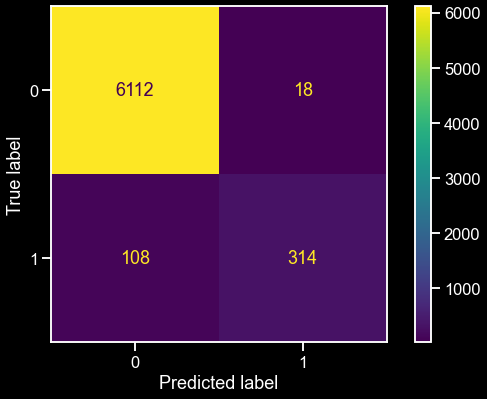

In [68]:
#Summarize the results
LSVC_best = gsLSVC.best_estimator_
print('Best : {}, using {}'.format(gsLSVC.best_score_,gsLSVC.best_params_))
report(gsLSVC)

In [69]:
# save the model to disk
with open('2gsLSVC.sav', 'wb') as filename:
    joblib.dump(gsLSVC, filename)

#### 7.2.3 Multinomial Naive Bayes Classification

In [70]:
# Train the model
MNB = MultinomialNB()

#Parameters
alpha=[1.0]
fit_prior=[True]

#ParametersGrid
mnb_param_grid = dict(alpha=alpha,fit_prior=fit_prior)

#GridSearchCV
gsMNB = GridSearchCV(MNB,param_grid = mnb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsMNB.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [1.0], 'fit_prior': [True]},
             scoring='accuracy', verbose=1)

Best : 0.9489107866173828, using {'alpha': 1.0, 'fit_prior': True}
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      6130
           1       0.94      0.31      0.47       422

    accuracy                           0.95      6552
   macro avg       0.95      0.65      0.72      6552
weighted avg       0.95      0.95      0.94      6552



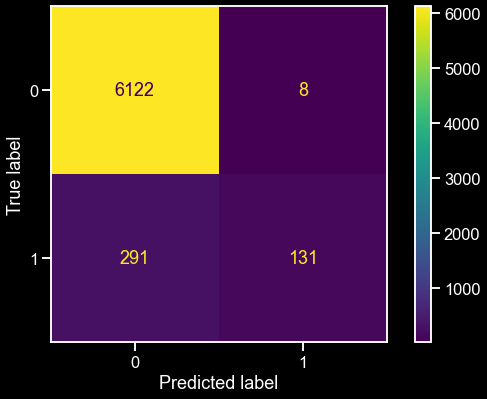

In [71]:
#Summarize the results
MNB_best = gsMNB.best_estimator_
print('Best : {}, using {}'.format(gsMNB.best_score_,gsMNB.best_params_))
report(gsMNB)
#Very poor recall values for 1

In [72]:
# save the model to disk
with open('3gsMNB.sav', 'wb') as filename:
    joblib.dump(gsMNB, filename)

#### 7.2.4 RandomForest

In [73]:
# Train the model
RFC = RandomForestClassifier()


#Parameters
rf_param_grid = {"max_depth": [15,20],
              "bootstrap": [False],
              "n_estimators" :[30,40,50],
              "criterion": ["gini"]}

#GridSearchCV
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsRFC.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [15, 20], 'n_estimators': [30, 40, 50]},
             scoring='accuracy', verbose=1)

Best : 0.9425655086600717, using {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6130
           1       1.00      0.09      0.17       422

    accuracy                           0.94      6552
   macro avg       0.97      0.55      0.57      6552
weighted avg       0.94      0.94      0.92      6552



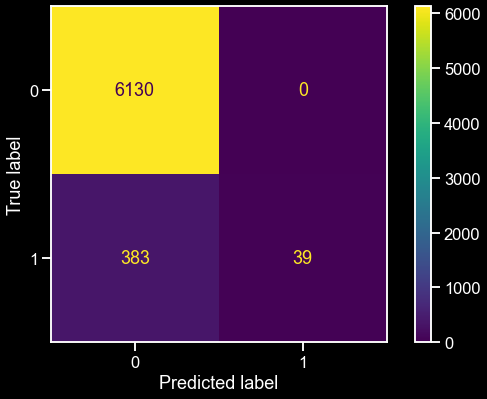

In [74]:
# Summarize the results
RFC_best = gsRFC.best_estimator_
print('Best : {}, using {}'.format(gsRFC.best_score_,gsRFC.best_params_))
report(gsRFC)
#Extremely Poor Recall values for 1

In [75]:
# save the model to disk
with open('4gsRFC.sav', 'wb') as filename:
    joblib.dump(gsRFC, filename)

#### 7.2.5 XGBooster

In [76]:
#Train the model
XGB = XGBClassifier()

#ParamGridSearch
xgb_param_grid = {"learning_rate"    : [0.075,0.1,0.2] ,
                  "max_depth"        : [17],
                  "gamma"            : [ 0.01]}

gsXGB = GridSearchCV(XGB,param_grid = xgb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsXGB.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[12:00:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=

Best : 0.9723296177938549, using {'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 17}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6130
           1       0.92      0.64      0.75       422

    accuracy                           0.97      6552
   macro avg       0.95      0.82      0.87      6552
weighted avg       0.97      0.97      0.97      6552



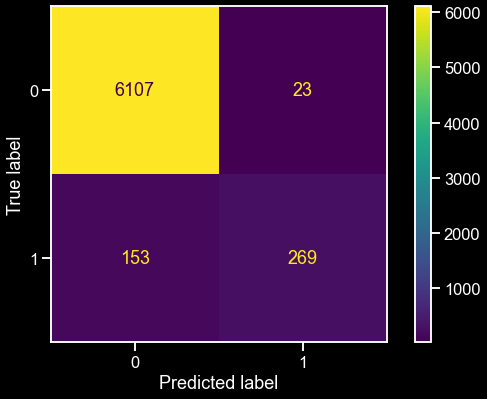

In [77]:
# Summarize the results
XGB_Best = gsXGB.best_estimator_
print('Best : {}, using {}'.format(gsXGB.best_score_,gsXGB.best_params_))
report(gsXGB)
#Average Recall values for 1

In [78]:
# save the model to disk
with open('5gsXGB.sav', 'wb') as filename:
    joblib.dump(gsXGB, filename)

##### 7.2.6 Perceptron

In [79]:
# Train the model
PPT = Perceptron()


#Parameters
ppt_param_grid = {"tol": [1e-5,1e-6],
              "class_weight": [None],
                  "early_stopping":[False]
                 }

#GridSearchCV
gsPPT = GridSearchCV(PPT,param_grid = ppt_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsPPT.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Perceptron(), n_jobs=-1,
             param_grid={'class_weight': [None], 'early_stopping': [False],
                         'tol': [1e-05, 1e-06]},
             scoring='accuracy', verbose=1)

Best : 0.9725256319166276, using {'class_weight': None, 'early_stopping': False, 'tol': 1e-05}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6130
           1       0.79      0.78      0.79       422

    accuracy                           0.97      6552
   macro avg       0.89      0.89      0.89      6552
weighted avg       0.97      0.97      0.97      6552



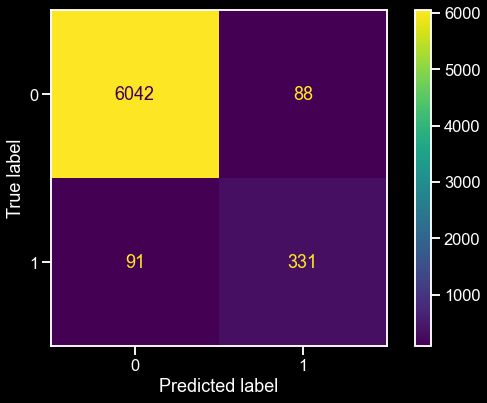

In [80]:
# Summarize the results
PPT_best = gsPPT.best_estimator_
print('Best : {}, using {}'.format(gsPPT.best_score_,gsPPT.best_params_))
report(gsPPT)
#Maybe an over fitted model. But average precison and recall for 1

In [81]:
# save the model to disk
with open('6gsPPT.sav', 'wb') as filename:
    joblib.dump(gsPPT, filename)

#### 7.2.7 Support Vector Machine

In [82]:
# Train the model
SVMC = SVC(probability=True)

# #Parameters
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.01],
                  'C': [150]}
#GridSearchCV
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsSVMC.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [150], 'gamma': [0.01], 'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

Best : 0.9765813827660328, using {'C': 150, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6130
           1       0.93      0.78      0.85       422

    accuracy                           0.98      6552
   macro avg       0.96      0.89      0.92      6552
weighted avg       0.98      0.98      0.98      6552



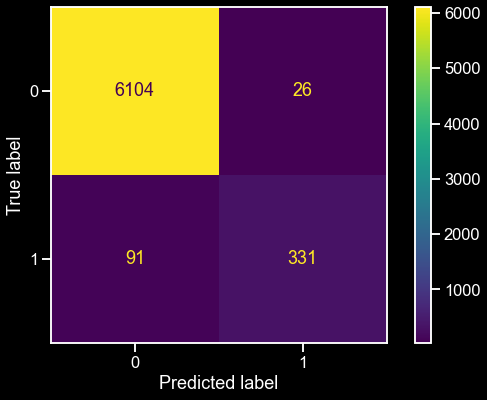

In [83]:
# Summarize the results
SVMC_best = gsSVMC.best_estimator_
print('Best : {}, using {}'.format(gsSVMC.best_score_,gsSVMC.best_params_))
report(gsSVMC)
#Good but a little low precision for 1

In [84]:
# save the model to disk
with open('7gsSVMC.sav', 'wb') as filename:
    joblib.dump(gsSVMC, filename)

### 7.3 Plotting Learning Curves
* Clearly visualize overfitting effect on the training set and the effect of the training size on the accuracy.
* We will choose ensemble models from the ones which generalise very well.

#### 7.2.1 Learning Curve function

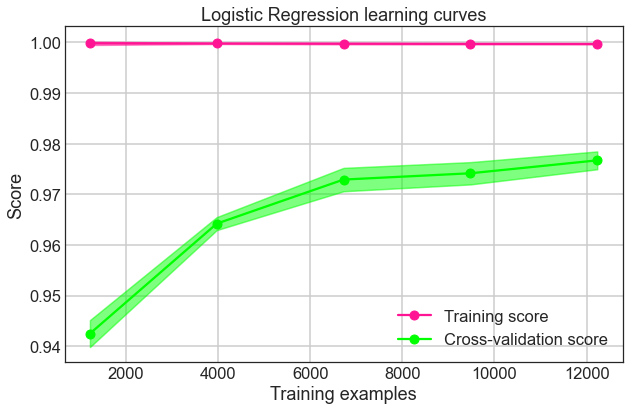

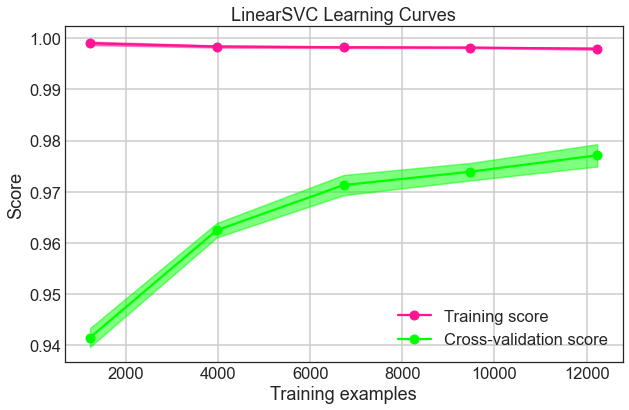

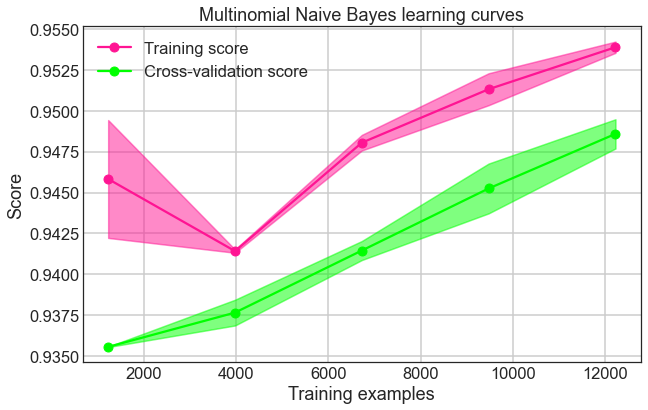

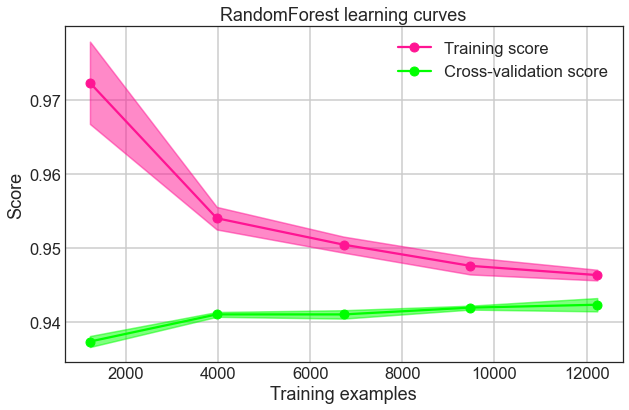

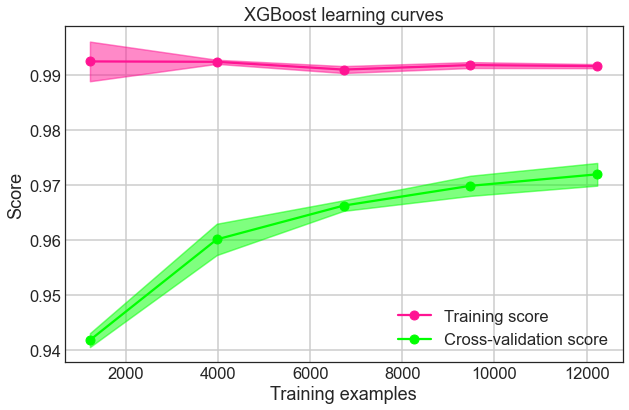

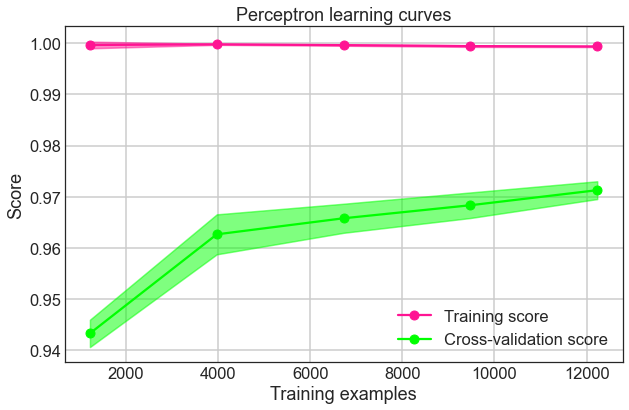

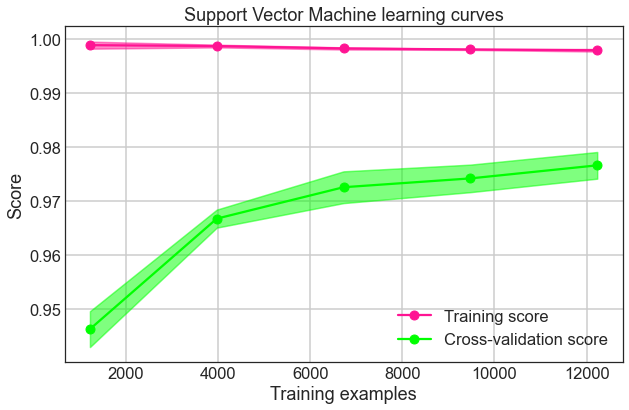

In [85]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
        #Setting White Theme
    sns.set(rc={'figure.figsize':(10,6.18)})
    sns.set(style="ticks", context="talk")
    plt.style.use("seaborn-white")
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.5,
                     color="deeppink")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.5, color="lime")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="deeppink",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="lime",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsLR.best_estimator_,"Logistic Regression learning curves",X_train,y_train,cv=kfold)

g = plot_learning_curve(gsLSVC.best_estimator_,"LinearSVC Learning Curves",X_train,y_train,cv=kfold)

g = plot_learning_curve(gsMNB.best_estimator_,"Multinomial Naive Bayes learning curves",X_train,y_train,cv=kfold)

g = plot_learning_curve(gsRFC.best_estimator_,"RandomForest learning curves",X_train,y_train,cv=kfold)

g = plot_learning_curve(gsXGB.best_estimator_,"XGBoost learning curves",X_train,y_train,cv=kfold)

g = plot_learning_curve(gsPPT.best_estimator_,"Perceptron learning curves",X_train,y_train,cv=kfold)

g = plot_learning_curve(gsSVMC.best_estimator_,"Support Vector Machine learning curves",X_train,y_train,cv=kfold)

#### 7.2.2 Inferences
* Logistic Regression and LinearSVC both are highly overfitted models with no generalization.
* Multinomial Naive Bayes have a fair level of Generalization. But it is constant as seen in the curve.
* RandomForest and XGBoost are greedy models and hence, overfitted models.
* Perceptron has good level of generalization which is constant as well.
* Support Vector also have some level of generalization but not as good as expected.

### 7.4 Ensemble Models

In [86]:
votingC = VotingClassifier(estimators=[('lr',LR_best),('xgb',XGB_Best),('rfc', RFC_best),('mnb', MNB_best),('lsvc',LSVC_best),('ppt',PPT_best),('svm',SVMC_best)], voting='hard', n_jobs=-1)
votingC = votingC.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6130
           1       0.95      0.71      0.82       422

    accuracy                           0.98      6552
   macro avg       0.97      0.86      0.90      6552
weighted avg       0.98      0.98      0.98      6552



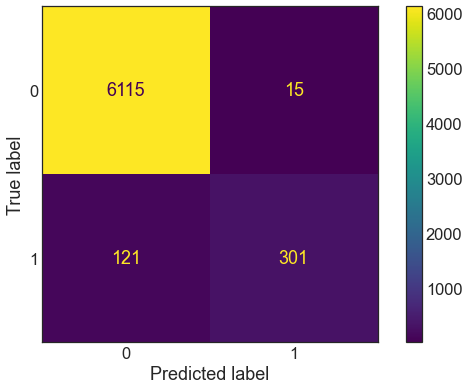

In [87]:
report(votingC) #POOR Recall for 1 and model seems overfitted

In [88]:
# save the model to disk
with open('8Ensemble.sav', 'wb') as filename:
    joblib.dump(votingC, filename)

### 7.5 Problems with ML Models
* All these baseline approaches are excellent in the case of numerical problems.
* However, Language cannot be considered numerically in this approach because the same text can have many interpretations.
* Unlike normal classfication problems where we can correct the imbalance via SMOTE or Undersampler, the same cannot be applied in the case of NLP. Duplicating or resampling values does not help much in NLP. The semantics and their meaning needs to be considered which is not suitable in the case ML approach.
* These tree-based models are GREEDY models. They just simply try to get the best accuracy without understanding the semantics in the case of NLP.
* While testing the models on realworld data, we came to the conclusion that for real world input emails, our base line approach is no good. Thats why we will consider Deep Learning Methodologies.

### 8. Why Deep Learning?
* Deep learning models and the word embedding techniques take the semantics into consideration. We will be able to know the difference between the same words in different sentences.

                I have an ant bite on my arm.
                It’s important to arm yourself with a solid education.
                
* In the above case, word2vec have hard coded same meaning. But BERT and TensorFow Embedding take semantics into consideration and provide great results during modelling.
* Deep learning models are very accurate in predicting our requirement in this project.

### 9. Deep Learning Modelling

#### 9.1 RNN with bidirectional LSTM
* This model will be built with the original dataset. There are a number of parameters that need to be considered in this case.
* Tensorflow librarires are quite light weight as compared to pytorch model.

##### 9.1.1 Building and Training the Model

In [89]:
corpus = df1["text"].to_list()
len(corpus)

21839

In [90]:
#Vocabulary size
voc_size=10000

onehot_repr = [one_hot(words, voc_size) for words in corpus]

In [91]:
#Embedding representation
sent_length = 200
embedding_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
embedding_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [92]:
#Building the LSTM model
embedding_vector_features = 50
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length =sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           500000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               120800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 621,001
Trainable params: 621,001
Non-trainable params: 0
_________________________________________________________________
None


In [93]:
len(embedding_docs)

21839

In [94]:
X_lstm=embedding_docs
y_lstm=np.array(y)

In [95]:
X_lstm.shape,y_lstm.shape

((21839, 200), (21839,))

In [96]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42)

In [97]:
model.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm,y_test_lstm),epochs=2, batch_size= 100)

Epoch 1/2
153/153 [==============================] - 89s 556ms/step - loss: 0.3155 - accuracy: 0.9221 - val_loss: 0.1398 - val_accuracy: 0.9483
Epoch 2/2
153/153 [==============================] - 81s 528ms/step - loss: 0.0893 - accuracy: 0.9677 - val_loss: 0.0968 - val_accuracy: 0.9689


In [98]:
def report(model):
    preds = model.predict_classes(X_test_lstm)
    print(classification_report(y_test_lstm,preds))

In [99]:
report(model)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6154
           1       0.83      0.62      0.71       398

    accuracy                           0.97      6552
   macro avg       0.90      0.80      0.84      6552
weighted avg       0.97      0.97      0.97      6552



In [100]:
# save the model to disk
model.save('lstm_tf')

INFO:tensorflow:Assets written to: lstm_tf\assets


INFO:tensorflow:Assets written to: lstm_tf\assets


#### 9.1.2 Testing on Real Data

In [101]:
sample1 = [ """On a dark desert highway, cool wind in my hair
Warm smell of colitas, rising up through the air
Up ahead in the distance, I saw a shimmering light
My head grew heavy and my sight grew dim
I had to stop for the night
There she stood in the doorway;
I heard the mission bell
And I was thinking to myself,
"This could be Heaven or this could be Hell"
Then she lit up a candle and she showed me the way
There were voices down the corridor,
I thought I heard them say...""" ]

sample2 = [ """Please fuck offf you ugly dumfucker"""]

In [102]:
onehot_sample1 = [one_hot(words, voc_size) for words in sample1]
onehot_sample2 = [one_hot(words, voc_size) for words in sample2]

In [103]:
embedding_sample1 = pad_sequences(onehot_sample1, padding='pre', maxlen=sent_length)
embedding_sample2 = pad_sequences(onehot_sample2, padding='pre', maxlen=sent_length)

In [104]:
pred_sample1 = model.predict_classes(embedding_sample1)
print(pred_sample1)
pred_sample2 = model.predict_classes(embedding_sample2)
print(pred_sample2)

#Note that there maybe wrong values in this model. 
#Not the wrong value (second output) below. BERT Model is much better than this since it was trained by Google on 2500M Data

[[1]]
[[1]]


### 9.2 Pytorch BERT Model
* This model was trained on high spec system with GPU CUDA.
* The weights were saved and loaded in this notebook.
* Link to the BERT Modelling which we did:
* This model is by far the best model we got so far.
* We trained this model using a balanced dataset rather than our original dataset

#### 9.2.1 Defining Model and Parameters

In [106]:
#Deep Learning Libraries - Pytorch BERT

import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast
# specify GPU
device = torch.device("cpu")

In [107]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased',from_tf=True)
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All TF 2.0 model weights were used when initializing BertModel.

All the weights of BertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [108]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [109]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [110]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [114]:
#load weights of best model
#path = 'saved_weights1.pt'
model.load_state_dict(torch.load(path))

#### 9.2.2 Testing on Real data

In [115]:
max_seq_len = 40

# tokenize and encode sequences in the test set1
tokens_test1 = tokenizer.batch_encode_plus(
    sample1,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set2
tokens_test2 = tokenizer.batch_encode_plus(
    sample2,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [116]:
# for test set1
test_seq1 = torch.tensor(tokens_test1['input_ids'])
test_mask1 = torch.tensor(tokens_test1['attention_mask'])

# for test set2
test_seq2 = torch.tensor(tokens_test2['input_ids'])
test_mask2 = torch.tensor(tokens_test2['attention_mask'])

In [117]:
# get predictions for test data
with torch.no_grad():
    preds1 = model(test_seq1.to(device), test_mask1.to(device))
    preds2 = model(test_seq2.to(device), test_mask2.to(device))
    preds1 = preds1.detach().cpu().numpy()
    preds2 = preds2.detach().cpu().numpy()

In [118]:
# model's performance
preds1 = np.argmax(preds1, axis = 1)
preds2 = np.argmax(preds2, axis = 1)
print(preds1)
print(preds2)

[1]
[1]


### 10. Conclusion:
* After trying out various feature engineering techniques and advanced modelling techniques, we understood that all these baseline approaches are poor predictors in any NLP problem.
* When it comes to NLP, semantics must be considered and that should be a primary requirement.
* Recall values are fundamental to modelling in NLP as we need to be careful when predicting a statement. Our prediction may have adverse effects on the user. Therefore, We understood that nlp models must have good recall in real world data.
* The deep learning models which we trained come at the cost of time and computational resourse. But the end resuls far outweight it's troubles.
* We will consider all models for deployment. The deployment will be coded via streamlit and shared using heroku.